https://www.tensorflow.org/tutorials/load_data/images, https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_lite/tflite_c04_exercise_convert_model_to_tflite_solution.ipynb

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
tf.__version__

'2.1.0-dev20191118'

## Retrieve images

You can download the test flowers images online or prepare your own local images. Each folder represents each class.

In [4]:
import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 117s 1us/step


In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [6]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

In [7]:
# Rename the dir into integer 
for item in data_dir.glob('*'):
    if item.name != "LICENSE.txt":
        name = np.where(CLASS_NAMES==item.name)[0][0]
        new = pathlib.Path(str(data_dir)+"/"+str(name))
        item.rename(new)

In [8]:
list_ds = tf.data.Dataset.list_files(str(data_dir)+'/*/*')

In [9]:
for f in list_ds.take(5):
    print(f.numpy())

b'C:\\Users\\Yiche\\.keras\\datasets\\flower_photos\\2\\1446097778_97149b8362.jpg'
b'C:\\Users\\Yiche\\.keras\\datasets\\flower_photos\\4\\7136973281_b2a935ce20.jpg'
b'C:\\Users\\Yiche\\.keras\\datasets\\flower_photos\\3\\4805544785_a63241f6d0_n.jpg'
b'C:\\Users\\Yiche\\.keras\\datasets\\flower_photos\\3\\4745985619_249078cafa_n.jpg'
b'C:\\Users\\Yiche\\.keras\\datasets\\flower_photos\\0\\20289938802_e16fa9f23d.jpg'


## Load images using tf.dataset
Create a dataset of image, label pairs for the mobile app. Here we use integer encoding instead of one hot encoding.

In [16]:
SHUFFLE_BUFFER_SIZE = image_count
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [10]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return tf.strings.to_number(parts[-2], tf.int32)

In [11]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    img = tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
    return img

In [12]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [17]:
list_ds = list_ds.shuffle(SHUFFLE_BUFFER_SIZE)

In [18]:
# loaded/processed images in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Image shape:  (224, 224, 3)
Label:  0
Image shape:  (224, 224, 3)
Label:  4


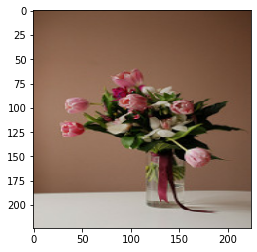

In [19]:
for image, label in labeled_ds.take(2):
    plt.imshow(image)
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

## Prepare for the training data
1. Create the dataset from slices of the filenames and labels
2. Shuffle the data with a buffer size equal to the length of the dataset. This ensures good shuffling (cf. this answer)
3. Parse the images from filename to the pixel values. Use multiple threads to improve the speed of preprocessing
4. (Optional for training) Data augmentation for the images. Use multiple threads to improve the speed of preprocessing 
5. Split the dataset into train, test and validation sets
6. Batch the images
7. Prefetch one batch to make sure that a batch is ready to be served at all time

We have done step 1, 2 and 3 above, the following code completes the next steps.

Source link: https://cs230-stanford.github.io/tensorflow-input-data.html#building-an-image-data-pipeline

In [20]:
BATCH_SIZE = 32

In [21]:
def preprocess_image(image, label):
    image = tf.image.random_flip_left_right(image)

    image = tf.image.random_brightness(image, max_delta=32.0 / 255.0)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)

    # Make sure the image is still in [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

In [22]:
# (optional) data augmentation
labeled_ds = labeled_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)

In [23]:
# split the labeled dataset into train, test and validation dataset
train_ds = labeled_ds.take(image_count//10*8)
test_ds = labeled_ds.take(image_count//10*1)
validation_ds = labeled_ds.take(image_count//10*1)

In [24]:
train_batches = train_ds.cache().shuffle(image_count//10*8).batch(BATCH_SIZE).prefetch(1)
test_batches = test_ds.cache().batch(1)
validation_batches = validation_ds.cache().batch(1)

# Train and save model

In [25]:
EPOCHS = 10
STEPS_PER_EPOCH = 5
NUMBER_OF_CLASSES = len(CLASS_NAMES)

In [26]:
# build a simple CNN model
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, 3, activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(NUMBER_OF_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
# train the model
model.fit(train_batches, 
          epochs=EPOCHS,
         steps_per_epoch=STEPS_PER_EPOCH,
         validation_data=validation_batches)

Train for 5 steps, validate for 367 steps
Epoch 1/10
5/5 [==============================] - 13s 3s/step - loss: 16.3335 - accuracy: 0.2375 - val_loss: 10.6651 - val_accuracy: 0.2098
Epoch 2/10
5/5 [==============================] - 7s 1s/step - loss: 5.9131 - accuracy: 0.2562 - val_loss: 2.1773 - val_accuracy: 0.1744
Epoch 3/10
5/5 [==============================] - 7s 1s/step - loss: 1.7824 - accuracy: 0.2188 - val_loss: 1.4850 - val_accuracy: 0.3406
Epoch 4/10
5/5 [==============================] - 7s 1s/step - loss: 1.4698 - accuracy: 0.3625 - val_loss: 1.4407 - val_accuracy: 0.4414
Epoch 5/10
5/5 [==============================] - 8s 2s/step - loss: 1.4374 - accuracy: 0.3438 - val_loss: 1.4411 - val_accuracy: 0.3706
Epoch 6/10
5/5 [==============================] - 7s 1s/step - loss: 1.4184 - accuracy: 0.3625 - val_loss: 1.4444 - val_accuracy: 0.4142
Epoch 7/10
5/5 [==============================] - 7s 1s/step - loss: 1.3747 - accuracy: 0.4437 - val_loss: 1.3502 - val_accuracy: 0.4

In [28]:
# save model
export_dir = 'saved_model'
tf.saved_model.save(model, export_dir)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model\assets


In [112]:
model.predict(test_batches.take(1))

array([[0.19093466, 0.20380947, 0.19011319, 0.20381926, 0.21132345]],
      dtype=float32)

In [124]:
test_batches

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

# Convert the training model
Tensorflow lite provides quantization techniques to optimize the model that allows for reduced precision representations of weights and, optionally, activations for both storage and computation. There are three ways which will be explained later.

In [29]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Test the converted model
Here we use the python interpreter to load a model and run an inference to test if the converted model works well, instead of the actual device. 

In [30]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

print(interpreter.get_input_details()[0])
print( interpreter.get_output_details()[0])

{'name': 'conv2d_input', 'index': 14, 'shape': array([  1, 224, 224,   3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}}
{'name': 'Identity', 'index': 0, 'shape': array([1, 5]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}}


In [31]:
# Gather results for the randomly sampled test images
predictions = []
test_labels = []
test_images = []

for img, label in test_batches.take(20):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(np.argmax(interpreter.get_tensor(output_index)))
    test_labels.append(label[0])
    test_images.append(np.array(img))

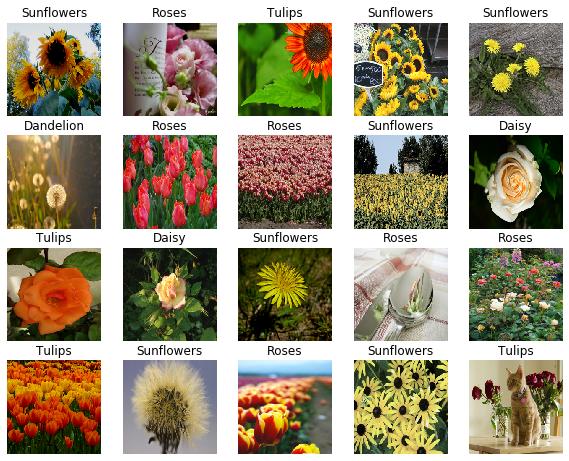

In [43]:
plt.figure(figsize=(10,10))
for i in range(20):
    ax = plt.subplot(5,5,i+1)
#     print("Actual label: " + CLASS_NAMES[test_labels[i].numpy()])
#     print("Predict label: " +  CLASS_NAMES[predictions[i]])
    plt.title(CLASS_NAMES[predictions[i]].title())
    img = np.squeeze(test_images[i])
    plt.imshow(img, cmap=plt.cm.binary)
    plt.axis('off')

# Save the tflite 

In [106]:
tflite_model_file = export_dir + '\\assets\model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

In [126]:
label_file = export_dir + '\\assets\labels.txt'
with open(label_file, 'w') as f:
    f.write('\n'.join(CLASS_NAMES))